# Generate an ensemble of ML models

We will attempt to model a portion of the empirical uncertainty that comes from the training data and optimization algorithm.  To do this, we will generate 30 models. For each iteration, two flux tower sites entire time-series will be removed from the training data and both a LGBM and RF will be fit on the remaining data.  This will result in 30 models that later we can use to make predictions 30 predictions. The IQR envelope of our predictions will inform our uncertainity


## Load modules

In [1]:
import os
import xarray as xr
import numpy as np
import seaborn as sb
import pandas as pd
from joblib import dump
from scipy import stats
import matplotlib.pyplot as plt
from pprint import pprint
from scipy.stats import gaussian_kde
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgbm
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, KFold
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

## Analysis Parameters

In [2]:
model_var = 'ET'
suffix = '20230320'
features_list = '/g/data/os22/chad_tmp/NEE_modelling/results/variables_'+suffix+'.txt'

## Prepare Data

In [3]:
base = '/g/data/os22/chad_tmp/NEE_modelling/results/training_data/'
sites = os.listdir('/g/data/os22/chad_tmp/NEE_modelling/results/training_data/')

td = []
for site in sites:
    if '.csv' in site:
        xx = pd.read_csv(base+site, index_col='time', parse_dates=True)
        xx['site'] = site[0:5]
        td.append(xx)

ts = pd.concat(td).dropna() #we'll use this later

In [4]:
train_vars = list(pd.read_csv(features_list))[0:-1]
train_vars=[i[:-3] for i in train_vars]
train_vars = [i+'_RS' for i in train_vars]
train_vars.append('site')
train_vars

['kNDVI_RS',
 'kNDVI_anom_RS',
 'LST_RS',
 'trees_RS',
 'grass_RS',
 'bare_RS',
 'C4_grass_RS',
 'LST-Tair_RS',
 'NDWI_RS',
 'rain_RS',
 'rain_anom_RS',
 'rain_cml3_anom_RS',
 'rain_cml6_anom_RS',
 'rain_cml12_anom_RS',
 'srad_RS',
 'srad_anom_RS',
 'vpd_RS',
 'tavg_RS',
 'tavg_anom_RS',
 'VegH_RS',
 'site']

In [5]:
xx = []
yy = []

for t in td:
    # t = t.drop(['Fluxcom_RS-Meteo_NEE', 'Fluxcom_RS_NEE', 'ThisStudy_NEE', 'Cable_NEE',
    #    'Fluxcom_RS_GPP', 'Fluxcom_RS-meteo_GPP', 'ThisStudy_GPP', 'Cable_GPP',
    #    'MODIS_GPP', 'GOSIF_GPP'], axis=1)  
    
    t = t.dropna()  # remove NaNS
    df = t.drop(['NEE_SOLO_EC','GPP_SOLO_EC','ER_SOLO_EC', 'ET_EC'], axis=1) # seperate fluxes
    
    #df = df.filter(regex='RS') # only use remote sensing variables   
    df = df[train_vars]
    
    if model_var == 'ET':
        df_var=t[[model_var+'_EC', 'site']]
    else:
        df_var=t[[model_var+'_SOLO_EC', 'site']] # seperate out the variable we're modelling
    
    x = df.reset_index(drop=True)#.to_numpy()
    y = df_var.reset_index(drop=True)#.to_numpy()
    xx.append(x)
    yy.append(y)

x = pd.concat(xx)
y = pd.concat(yy)

print(x.shape)


(2825, 21)


### Generate 30 iterations of models

For two regression methods (RF and LigtGBM), we remove two randomly selected sites from the training data

Then, we do the per site TSCV: For each site, grab a sequential set of test samples (time-series-split methods), the remaining points (either side of test samples) go into training.  A single K-fold contains test and training samples from every site.

A model is built and saved that is trained of 15 iterations of site removal


In [6]:
%%time
i=0
for m in range(1,16): # 15 iterations for each model
    print(" {:03}/{:03}\r".format(m, len(range(1,16))))
          
    #randomly select two sites to remove from dataset
    subset=np.random.choice(x['site'].unique(), size=2)
    x_n = x[~x.site.isin(subset)]
    y_n = y[~y.site.isin(subset)]

    sites_n = x_n['site'].unique()
    x_n['original_index'] = [i for i in range(0,len(x_n))]
    
    #build TSCV splits across all remaining sites
    train_1=[]
    train_2=[]
    train_3=[]
    train_4=[]
    train_5=[]

    test_1=[]
    test_2=[]
    test_3=[]
    test_4=[]
    test_5=[]

    for site_n in sites_n:
        df = x_n.loc[x_n['site'] == site_n]
        tscv = TimeSeriesSplit(n_splits=5)
        i=1
        for train, test in tscv.split(df):
            all_indices=np.concatenate([train,test])
            left_over = df.loc[~df.index.isin(all_indices)].index.values
            train = np.concatenate([train, left_over])
            if i==1:
                train_1.append(df.iloc[train]['original_index'].values)
                test_1.append(df.iloc[test]['original_index'].values)
            if i==2:
                train_2.append(df.iloc[train]['original_index'].values)
                test_2.append(df.iloc[test]['original_index'].values)
            if i==3:
                train_3.append(df.iloc[train]['original_index'].values)
                test_3.append(df.iloc[test]['original_index'].values)
            if i==4:
                train_4.append(df.iloc[train]['original_index'].values)
                test_4.append(df.iloc[test]['original_index'].values)
            if i==4:
                train_5.append(df.iloc[train]['original_index'].values)
                test_5.append(df.iloc[test]['original_index'].values)
            i+=1

    train_1 = np.concatenate(train_1)
    train_2 = np.concatenate(train_2)
    train_3 = np.concatenate(train_3)
    train_4 = np.concatenate(train_4)
    train_5 = np.concatenate(train_5)

    test_1 = np.concatenate(test_1)
    test_2 = np.concatenate(test_2)
    test_3 = np.concatenate(test_3)
    test_4 = np.concatenate(test_4)
    test_5 = np.concatenate(test_5)

    train = [train_1, train_2, train_3, train_4, train_5]
    test = [test_1, test_2, test_3, test_4, test_5]

    #check there are no train indices in the test indices
    for i,j in zip(train, test):
        assert (np.sum(np.isin(i,j)) == 0)

    #remove the columns we no longer need
    x_n = x_n.drop(['site', 'original_index'], axis=1)
    y_n = y_n.drop('site', axis=1)

    #loop through the two regression methods
    for regressor in [LGBMRegressor,
                      RandomForestRegressor]:

        if isinstance(regressor(), lgbm.sklearn.LGBMRegressor):
            m_name='_lgbm_'

            param_grid_lgbm = {
                'num_leaves': stats.randint(5,40),
                'min_child_samples':stats.randint(10,30),
                'boosting_type': ['gbdt', 'dart'],
                'max_depth': stats.randint(5,25),
                'n_estimators': [300, 400, 500],
            }

        else:
            m_name='_rf_'

            param_grid_rf = {
                'max_depth': stats.randint(5,35),
                'max_features': ['log2', None, "sqrt"],
                'n_estimators': [200,300,400,500]}

        print('  Model:', m_name)
        
        #-----Nested CV to test accuracy-----------------------------------------------
        # results are saved as a .csv 
        j=1
        for train_index, test_index in zip(train, test):
            print(f"    {j}/{len(train)} outer cv split")
            
            if os.path.exists("/g/data/os22/chad_tmp/NEE_modelling/results/cross_validation/"+model_var+"_ensemble/CV_"+str(j)+"_"+model_var+m_name+str(m)+".csv"):
                j+=1
                continue

            # index training, testing
            X_tr, X_tt = x_n.iloc[train_index, :], x_n.iloc[test_index, :]
            y_tr, y_tt = y_n.iloc[train_index], y_n.iloc[test_index]

            #simple random split on inner fold
            inner_cv = KFold(n_splits=5,
                             shuffle=True,
                             random_state=0)

            if m_name=='_rf_':
                model = regressor(random_state=1, verbose=0)
                clf = RandomizedSearchCV(
                               model,
                               param_grid_rf,
                               verbose=0,
                               n_iter=250,
                               n_jobs=-1,
                               cv=inner_cv.split(X_tr, y_tr),
                              )

                clf.fit(X_tr, y_tr.values.ravel())

            else:
                model = regressor(random_state=1, verbose=-1)
                clf = RandomizedSearchCV(
                               model,
                               param_grid_lgbm,
                               verbose=-1,
                               n_iter=250,
                               n_jobs=-1,
                               cv=inner_cv.split(X_tr, y_tr),
                              )
                clf.fit(X_tr, y_tr, callbacks=None)


            # predict using the best model
            best_model = clf.best_estimator_
            pred = best_model.predict(X_tt)
            dff = pd.DataFrame({'Test':y_tt.values.squeeze(), 'Pred':pred}).reset_index(drop=True)
            dff.to_csv("/g/data/os22/chad_tmp/NEE_modelling/results/cross_validation/"+model_var+"_ensemble/CV_"+str(j)+"_"+model_var+m_name+str(m)+".csv")

            j+=1
        #-----End of Nested CV ---------------------------------------------------
        
        if os.path.exists('/g/data/os22/chad_tmp/NEE_modelling/results/models_uncertainty/'+model_var+'/'+m_name+str(m)+'.joblib'):
                print('    fit model and export')
                continue
 
        # Now conduct a hyperparameter test on all the data
        # (minus the two removed sites) and fit a model
        print('    fit model and export')
        if m_name=='_rf_':
            model = regressor(random_state=1, verbose=0)
            clf = RandomizedSearchCV(
                   model,
                   param_grid_rf,
                   verbose=0,
                   n_iter=500,
                   n_jobs=-1,
                   cv=zip(train, test)
                  )

            clf.fit(x_n, y_n.values.ravel())    
            model = regressor(**clf.best_params_)
            model.fit(x_n, y_n.values.ravel())

        else:
            model = regressor(random_state=1, verbose=-1)
            clf = RandomizedSearchCV(
                   model,
                   param_grid_lgbm,
                   verbose=-1,
                   n_iter=500,
                   n_jobs=-1,
                   cv=inner_cv.split(X_tr, y_tr),
                  )
            clf.fit(x_n, y_n, callbacks=None)
            model = regressor(**clf.best_params_)
            model.fit(x_n, y_n)    

        dump(model, '/g/data/os22/chad_tmp/NEE_modelling/results/models_uncertainty/'+model_var+'/'+m_name+str(m)+'.joblib')

    i+=1

 001/015
  Model: _lgbm_
    1/5 outer cv split
    2/5 outer cv split
    3/5 outer cv split
    4/5 outer cv split
    5/5 outer cv split
    fit model and export
  Model: _rf_
    1/5 outer cv split
    2/5 outer cv split
    3/5 outer cv split
    4/5 outer cv split
    5/5 outer cv split
    fit model and export
 002/015
  Model: _lgbm_
    1/5 outer cv split
    2/5 outer cv split
    3/5 outer cv split
    4/5 outer cv split
    5/5 outer cv split
    fit model and export
  Model: _rf_
    1/5 outer cv split
    2/5 outer cv split
    3/5 outer cv split
    4/5 outer cv split
    5/5 outer cv split
    fit model and export
 003/015
  Model: _lgbm_
    1/5 outer cv split
    2/5 outer cv split
    3/5 outer cv split
    4/5 outer cv split
    5/5 outer cv split
    fit model and export
  Model: _rf_
    1/5 outer cv split
    2/5 outer cv split
    3/5 outer cv split
    4/5 outer cv split
    5/5 outer cv split
    fit model and export
 004/015
  Model: _lgbm_
    1/5 outer cv s

### Create 1:1 plots and statistics

In [7]:
model_var='ET'

In [8]:
base='/g/data/os22/chad_tmp/NEE_modelling/results/cross_validation/'+model_var+'_ensemble/'

df_list=[]
r2_list=[]
ac_list=[]
#get the list of cvs corresponding with a given CV split
csvs = [i for i in os.listdir(base) if i.endswith('.csv')]
for i in csvs:
    df = pd.read_csv(base+i, usecols=['Test', 'Pred'])
    obs,pred = df['Test'].values, df['Pred'].values
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    r2_list.append(r_value**2)
    ac_list.append(mean_absolute_error(obs, pred))
    df_list.append(df)
    

#concantenate all the data  for the given CV split
cross_df = pd.concat(df_list)

### Calculate stats

In [9]:
obs,pred = cross_df['Test'].values, cross_df['Pred'].values
slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
r2 = r_value**2
ac = mean_absolute_error(obs, pred)

### Create figure

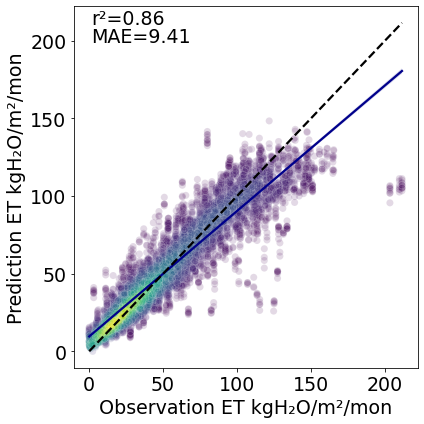

In [16]:
fig,ax = plt.subplots(1,1, figsize=(6,6))
font=19
cross_df = cross_df.sample(n=10000)

xy = np.vstack([cross_df['Test'],cross_df['Pred']])
z = gaussian_kde(xy)(xy)

sb.scatterplot(data=cross_df, x='Test',y='Pred',c=z, s=50, lw=1, alpha=0.15, ax=ax)
sb.regplot(data=cross_df, x='Test',y='Pred', scatter=False, color='darkblue', ax=ax)
sb.regplot(data=cross_df, x='Test',y='Test', color='black', scatter=False, line_kws={'linestyle':'dashed'}, ax=ax);

if model_var != 'ET':
    ax.set_xlabel('Observation '+ model_var + ' gC m\N{SUPERSCRIPT TWO} mon⁻¹', fontsize=font)
    ax.set_ylabel('Prediction ' + model_var+ ' gC m\N{SUPERSCRIPT TWO} mon⁻¹', fontsize=font)

else:
    ax.set_xlabel('Observation '+ model_var + ' kgH\N{SUBSCRIPT TWO}O/m\N{SUPERSCRIPT TWO}/mon', fontsize=font)
    ax.set_ylabel('Prediction ' + model_var+ ' kgH\N{SUBSCRIPT TWO}O/m\N{SUPERSCRIPT TWO}/mon', fontsize=font)
    
ax.text(.05, .95, 'r\N{SUPERSCRIPT TWO}={:.2f}'.format(r2),
            transform=ax.transAxes, fontsize=19)
ax.text(.05, .9, 'MAE={:.3g}'.format(ac),
            transform=ax.transAxes, fontsize=19)
ax.tick_params(axis='x', labelsize=font)
ax.tick_params(axis='y', labelsize=font)

plt.tight_layout()

fig.savefig("/g/data/os22/chad_tmp/NEE_modelling/results/cross_validation/cross_val_"+model_var+"_ensemble_"+suffix+".png", bbox_inches='tight')

## Ensemble feature importance

Derived by calculating the mean absolute SHAP values for each feature in each model iteration, and subsequently averaging those values across all the models in the ensemble.

RF feature importance takes a very long time!

In [ ]:
from joblib import load
import shap
import os

In [ ]:
var='ET'
models_folder = '/g/data/os22/chad_tmp/NEE_modelling/results/models_uncertainty/'+var+'/'

In [ ]:
model_list = [file for file in os.listdir(models_folder) if file.endswith(".joblib")]

In [ ]:
#remove the columns we no longer need
x = x.drop(['site'], axis=1)
y = y.drop(['site'], axis=1)

In [ ]:
%%time
dffs=[]
i=1
for m in model_list:
    print(f"{i}/{len(model_list)}", end='\r')
    
    if 'rf' in m:
        #continue
        explainer = shap.TreeExplainer(model = load(models_folder+m), data=x)
    
    else:
        explainer = shap.Explainer(model = load(models_folder+m))
    
    shap_values = explainer(x)
    vals = np.abs(shap_values.values).mean(0)
    df = pd.DataFrame(list(zip(x.columns, vals)), columns=['col_name',m[0:-7]+'_FI'])
    df.sort_values(by=[m[0:-7]+'_FI'],ascending=False,inplace=True)
    df['col_name'] = df['col_name'].str.removesuffix("_RS")
    df = df.set_index('col_name', drop=True)
    dffs.append(df)
    i += 1

In [ ]:
df = pd.concat(dffs, axis=1)
df['mean'] = df.mean(axis=1)
# df['stddev'] = df.std(axis=1)
df = df.T

### Plot

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
sb.barplot(data = df.sort_values(by='mean', axis=1, ascending=False).iloc[:, : 5].iloc[0:30], orient='h', ax=ax, palette='Blues_r')
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.set_xlabel('Ensemble average of mean absolute SHAP values for '+ var, fontsize=20)
ax.set_ylabel('')
plt.tight_layout()
fig.savefig("/g/data/os22/chad_tmp/NEE_modelling/results/cross_validation/feature_importance_"+var+"_ensemble_"+suffix+".png", bbox_inches='tight')